## Simulating any compartmental model using the `Spp` class

In the present notebook, we show how (most) compartmenal models can be simulated using the `pyross.stochastic.Spp` class. We allow users to specify any number of epidemiological classes, as well as any linear or infectious coupling between them.

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model

Below you will find the model-specification dictionary for the SIR model with some constant injection into the S class:

In [3]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "constant"  : [ ["k"] ], 
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ]
    }
}



This corresponds to

$$
\begin{aligned}
\dot{S}_i & = - \beta \sum_\nu C_{ij} \frac{I_j}{N_j} S_i \\
\dot{I}_i & = \beta \sum_\nu C_{ij} \frac{I_j}{N_j} - \gamma I_i \\
\dot{R}_i & = \gamma I_i^\mu
\end{aligned}
$$

Let's go through each component of the model specification step-by-step:

-  The list `"classes" : ["S", "I", "R"]` defines the epidemiological
classes of the model. <i>The order in which they are written are important</i>, as this ordering will have to be mainained if giving the initial conditions of the simulation as an array. Each model requires the presence of a susceptible class. This class
will always be the first element of the list `classes`, regardless of whether it is labelled as `S` or not.
- The dynamics of each class is defined by a key-value pair. Consider

    <br>

    ```json
    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["I", "betaI"], ["A", "betaA"] ]
    },
    ```
    
    <br>
    
  - This reads out as:
      $$\dot{E}^\mu = -\gamma_E E + \beta_I \sum_\nu C^I_{\mu \nu} \frac{I^\nu}{N^\nu} S^\mu + \beta_A \sum_\nu C^A_{\mu \nu} \frac{A^\nu}{N^\nu} S^\mu.$$
  - The linear terms for each epidemic class is defined by the lists of lists:
  
    <br>
    
    ```json
    "linear"    : [ ["E", "-gammaE"] ]
    ```
    
    <br>
    
    Eeach pair in `linear` corresponds to the linear coupling 
    with the class and the coupling constant respectively. So
    `["E", "-gammaE"]` corresponds to the term $-\gamma_E E$ in
    the equation for $\dot{E}$. The minus sign in front of `gammaE`
    signifies that the negative of the coefficient should be used.
  - The infection terms are defined in a similar manner. Each pair
    in `infection` corresponds to the non-linear coupling with $S$
    and the coupling constant respectively. So `["I", "betaI"]`
    corresponds to the term $\beta_I \sum_\nu C^I_{\mu \nu} \frac{I^\nu}{N^\nu} S$.

Next, we define the parameter values:

In [4]:
parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
}

The initial conditions can be defined in either of two ways. They can either be defined using a dictionary, where for each model class we have a corresponding 1D array of length $M$ (where $M$ is the number of age-groups), or a numpy array. The numpy array must have dimensions $M \times (d-1)$, where $d$ is the number of model classes (so 3 for SIR, for example).

If the initial conditions are provided as a dictionary, we are free to leave out one of the classes. In which case the initial conditions of the left out class will be inferred from the others.

In [5]:
M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    999, 1000, 1000, # S
    1,   0,    0,    # I
])

# Or initial conditions as a dictionary 
I0 = [10, 10, 10]
S0 = [n-20 for n in Ni]

x0 = {
    'S' : S0,
    'I' : I0 
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

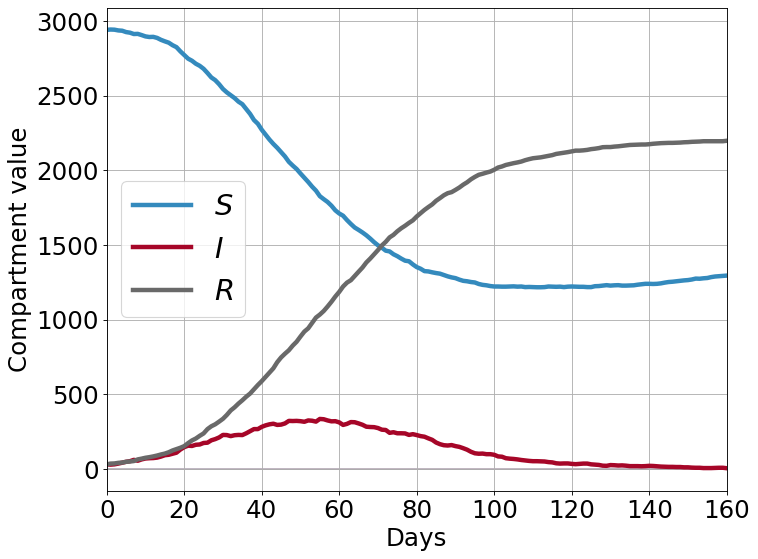

In [6]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

We can use `pyross.stochastic.Spp.update_model_parameters` to change the parameters from what we set them initially:

In [7]:
parameters = {
    'beta' : 0.1,
    'gamma' : 0.01,
    'k':1
}

model.update_model_parameters(parameters)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

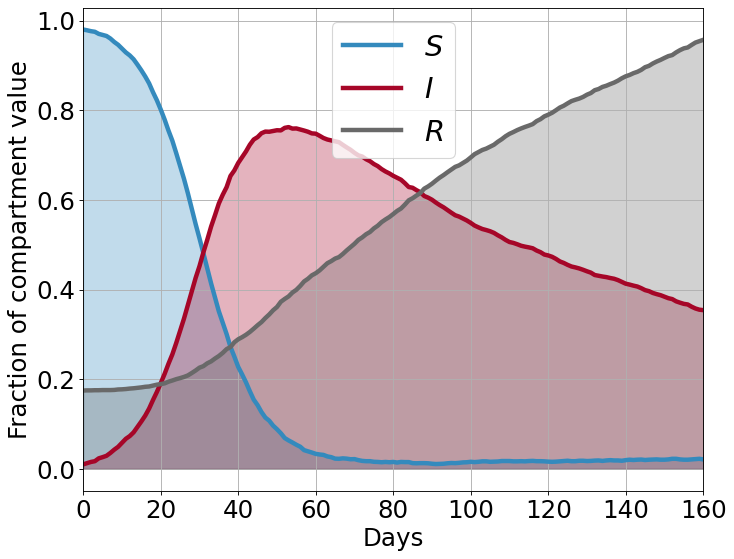

In [8]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I/N, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Fraction of compartment value')
plt.xlabel('Days');

### SEAIR model

Let us now look at a more complicated example.

In [9]:
model_spec = {
    "classes" : ["S", "E", "A", "Ia", "Is"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["A", "-beta"], ["Ia", "-beta"], ["Is", "-beta"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["A", "beta"], ["Ia", "beta"], ["Is", "beta"] ]
    },
    
    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-alphabar*gammaA"], ["A", "-alpha*gammaA"] ],
        "infection" : [ ]
    },

    "Ia" : {
        "linear"    : [ ["A", "alpha*gammaA"],["Ia", "-gammaIa"] ],
        "infection" : [ ]
    },
    
    "Is" : {
        "linear"    : [ ["A", "alphabar*gammaA"], ["Is", "-gammaIs"] ],
        "infection" : [ ]
    }
}

gammaA = 0.2
alpha = 0.4              # fraction of asymptomatic infectives

parameters = {
    'beta' : 0.2,
    'gammaE' : 0.04,
    'alpha*gammaA' : alpha*gammaA,
    'alphabar*gammaA' : (1 - alpha)*gammaA,
    'gammaIa' : 0.1,
    'gammaIs' : [0.1,0.1, 0.1],
}

This corresponds to

$$
\begin{aligned}
\dot{S}_i & = - \lambda_i(t) S_i  \\
\dot{E}_i & = \lambda_i(t) S_i - \gamma_E E_i \\
\dot{A}_i & = \gamma_E E_i - \gamma_A A_i \\
\dot{I^a}_i & =  \alpha \gamma_A A  - \gamma_I^a I^a_i \\
\dot{I^s}_i & =  (1 - \alpha)\gamma_A A  - \gamma_I^s I^s_i \\
\dot{R}_i & = \gamma_I^a I^a_i + \gamma_I^s I^s_i
\end{aligned}
$$

where

$$
\lambda_i(t) = \sum_j C_{ij} \left( \beta_I^a  \frac{I^a_j}{N_j} + \beta_I^s  \frac{I^s_j}{N_j} + \beta_A  \frac{A_j}{N_j}\right).
$$


$$
C_{ij}  \beta_I^a  \frac{I^a_j}{N_j}
$$

In [10]:
M = 3                
Ni = 10000*np.ones(M)   
N = np.sum(Ni) 

E0 = np.array([0,0,0])
A0 = np.array([100,0,0])
Ia0 = np.array([0,0,0])
Is0 =  np.array([0,0,0])
S0 = Ni - np.array([100,0,0])

x0 = {
    'E' : E0,
    'A' : A0,
    'Ia' : Ia0,
    'Is' : Is0,
    'S' : S0
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):   
    return CM

# duration of simulation and data file
Tf = 300;  Nt=301; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nt)
t_spp = data['t']



# create an idential hardcoded SEAIR model 
parameters_for_hardcoded_model = {
    'alpha' : alpha, 
    'beta' : 0.2,
    'gE' : 0.04,
    'gA' : gammaA,
    'gIa' : 0.1,
    'gIs' : 0.1,
    'fsa' : 1
}
model_hardcoded = pyross.deterministic.SEAIR(parameters_for_hardcoded_model, M, Ni)

# simulate model 
data_hardcoded = model_hardcoded.simulate(S0, E0, A0, Ia0, Is0, contactMatrix, Tf, Nt)

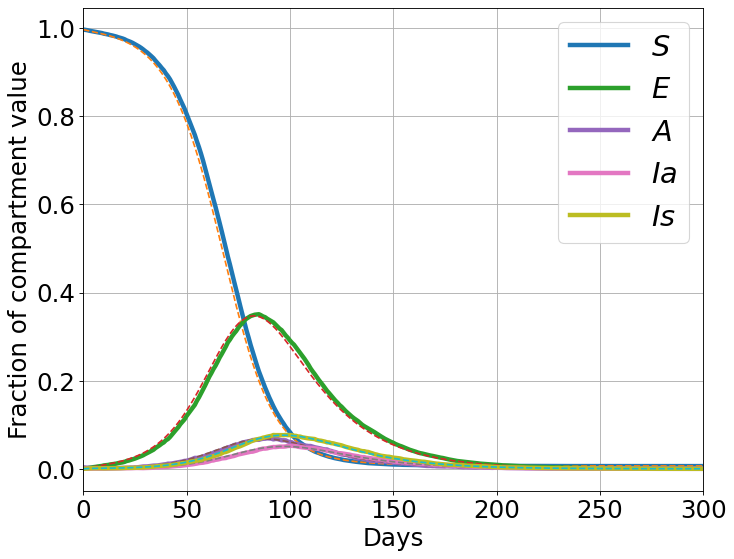

In [11]:
# plot the data and obtain the epidemic curve

t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

X_hardcoded = data_hardcoded['X'].reshape((Nt, 5, M))

for i, model_class in enumerate(model_spec['classes']):
    Os = np.sum(model.model_class_data(model_class, data), axis=1)
    plt.plot(t, Os/N, '-', label='$%s$' % model_class, lw=4)
    plt.plot(t, np.sum(X_hardcoded[:, i, :], axis=1)/N, '--')

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Fraction of compartment value')
plt.xlabel('Days');

### SEAI8R

In [12]:
model_spec = {
    "classes" : ["S", "E", "Ia", "Is", "Is'", "Ih", "Ih'", "Ic", "Ic'", "Im"],

    "S" : {
        "linear" :      [ ],
        "infection" :   [ ["Ia", "-beta"], ["Is", "-beta"] ]
    },

    "E" : {
        "linear" :      [ ["E", "-a*gammaE"], ["E", "-abar*gammaE"] ],
        "infection" :   [ ["Ia", "beta"], ["Is", "beta"] ]
    },

    "Ia" : {
        "linear" :      [ ["E", "a*gammaE"], ["Ia", "-gammaIa"] ],
        "infection" :   [ ]
    },

    "Is" : {
        "linear" :      [ ["E", "abar*gammaE"], ["Is", "-h*gammaIs"], ["Is", "-hbar*gammaIs"]],
        "infection" :   [ ]
    },

    "Is'" : {
        "linear" :      [ ["Is", "hbar*gammaIs"], ["Is'", "-gammaIs'"] ],
        "infection" :   [ ]
    },

    "Ih" : {
        "linear" :      [ ["Is", "h*gammaIs"], ["Ih", "-c*gammaIh"], ["Ih", "-cbar*gammaIh"]],
        "infection" :   [ ]
    },

    "Ih'" : {
        "linear" :      [ ["Ih", "cbar*gammaIh"], ["Ih'", "-gammaIh'"] ],
        "infection" :   [ ]
    },

    "Ic" : {
        "linear" :      [ ["Ic", "c*gammaIh"], ["Ic", "-m*gammaIc"], ["Ic", "-mbar*gammaIc"]],
        "infection" :   [ ]
    },

    "Ic'" : {
        "linear" :      [ ["Ic", "mbar*gammaIc"], ["Ic'", "-gammaIc'"] ],
        "infection" :   [ ]
    },

    "Im" : {
        "linear" :      [ ["Ic", "m*gammaIc"] ],
        "infection" :   [ ]
    }
}

a = 0.4
h = 0.1
c = 0.12
m = 0.13
beta = 0.2 

gammaE = np.array([0.3, 0.5, 0.6])*0.1
gammaIa = np.array([0.3, 0.5, 0.6])*0.1
gammaIs = np.array([0.3, 0.5, 0.6])*0.1
gammaIh = np.array([0.3, 0.5, 0.6])*0.1
gammaIc = np.array([0.3, 0.5, 0.6])*0.1

parameters = {
    'beta' : beta,
    'gammaE' : gammaE,
    'a*gammaE' : a*gammaE,
    'abar*gammaE' : (1-a)*gammaE,
    'gammaIa' : gammaIa,
    'gammaIs' : gammaIs,
    'h*gammaIs' : h*gammaIs,
    'hbar*gammaIs' : (1-h)*gammaIs,
    'gammaIh' : gammaIh,
    'c*gammaIh' : c*gammaIh,
    'cbar*gammaIh' : (1-c)*gammaIh,
    'gammaIc' : gammaIc,
    'm*gammaIc' : m*gammaIc,
    'mbar*gammaIc' : (1-m)*gammaIc,
    "gammaIh'" : 0.1,
    "gammaIc'": 0.1,
    "gammaIs'" : 0.1
}

In [13]:
M = 3                
Ni = 10000*np.ones(M)   
N = np.sum(Ni)        

x0 = {
    'E' : np.array([10,0,0]),
    'Ia' : np.array([0,0,0]),
    'Is' : np.array([0,0,0]),
    'Ih' : np.array([0,0,0]),
    'Ic' : np.array([0,0,0]),
    "Is'" : np.array([0,0,0]),
    "Ih'" : np.array([0,0,0]),
    "Ic'" : np.array([0,0,0]),
    'Im' : np.array([0,0,0]),
    'S' : Ni - np.array([10,0,0])
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):   
    return CM

# duration of simulation and data file
Tf = 300;  Nt=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nt)

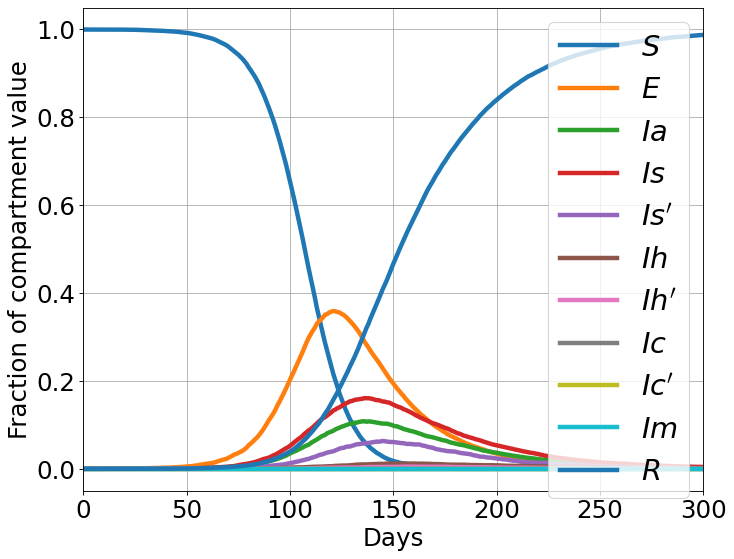

In [14]:
# plot the data and obtain the epidemic curve

t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

for model_class in (model_spec['classes'] + ['R'] ):
    Os = np.sum(model.model_class_data(model_class, data), axis=1)
    plt.plot(t, Os/N, '-', label='$%s$' % model_class, lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Fraction of compartment value')
plt.xlabel('Days');